# HAMP
The following example demonstrates the use of HAMP raw data collected during HALO-AC3. The HALO Microwave Package (HAMP) belongs to Max-Planck Institute for Meteorology Hamburg, DLR/IPA, and the University of Hamburg. The package consists of a 35 GHz pulsed radar and three passive microwave modules with a frequency range of 22 to 183.31 +/- 7.5 GHz.

More information on the instrument can be found in [Mech et al. (2014)](https://amt.copernicus.org/articles/7/4539/2014/) and [Ewald et al. 2019](https://amt.copernicus.org/articles/12/1815/2019/). If you have questions or if you would like to use the data for a publication, please don't hesitate to get in contact with the dataset authors as stated in the dataset attributes `contact` or `author`.

## Data access
Some of the data, like the preliminary data of the HALO-(AC)<sup>3</sup> campaign, is stored on the (AC)<sup>3</sup> nextcloud server. This requires username and password as credentials ([registration](https://cloud.ac3-tr.de/index.php/login)) that need to be loaded from environment variables. 

In [1]:
import os
ac3cloud_username = os.environ['AC3_USER']
ac3cloud_password = os.environ['AC3_PASSWORD']

To analyse the data they first have to be loaded by importing the (AC)<sup>3</sup> airborne module and load the meta data catalog. To do so, the ac3airborne package has to be installed. More information on how to do that and about the catalog can be found [here](https://github.com/igmk/ac3airborne-intake#ac3airborne-intake-catalogue).

In [2]:
import ac3airborne

Show available data sets

In [3]:
cat = ac3airborne.get_intake_catalog()

In [4]:
list(cat['HALO-AC3']['HALO'])

['BAHAMAS',
 'BACARDI',
 'DROPSONDES',
 'GPS_INS',
 'GOPRO',
 'HAMP_KV',
 'HAMP_11990',
 'HAMP_183',
 'HAMP_MIRA',
 'SMART']

Get the flight segments. We need to load an older version that includes the HALO-AC3 flights. The version labeled _latest_ only holds flights from campaigns pre HALO-AC3.

In [5]:
meta = ac3airborne.get_flight_segments()

In [6]:
flight = 'HALO-AC3_HALO_RF02'

Load GPS and INS recorded by the SMART instrument and get takeoff and landing times.

In [7]:
gps_ins = cat['HALO-AC3']['HALO']['GPS_INS'][flight](user=ac3cloud_username,password=ac3cloud_password).to_dask()

takeoff = meta['HALO-AC3']['HALO'][flight]['takeoff']
landing = meta['HALO-AC3']['HALO'][flight]['landing']

Invalid MIT-MAGIC-COOKIE-1 key

In [8]:
import datetime
hamp_kv = cat['HALO-AC3']['HALO']['HAMP_KV'][flight](user=ac3cloud_username,password=ac3cloud_password).to_dask().sel(time=slice(takeoff, landing))
hamp_11990 = cat['HALO-AC3']['HALO']['HAMP_11990'][flight](user=ac3cloud_username,password=ac3cloud_password).to_dask().sel(time=slice(takeoff, landing))
hamp_183 = cat['HALO-AC3']['HALO']['HAMP_183'][flight](user=ac3cloud_username,password=ac3cloud_password).to_dask().sel(time=slice(takeoff, landing))
#hamp_mira = cat['HALO-AC3']['HALO']['HAMP_MIRA'][flight](user=ac3cloud_username,password=ac3cloud_password).to_dask().sel(time=slice(datetime.datetime(2022,3,12,9,0,0), datetime.datetime(2022,3,12,16,0,0)))
hamp_mira = cat['HALO-AC3']['HALO']['HAMP_MIRA'][flight](user=ac3cloud_username,password=ac3cloud_password).to_dask().sel(time=slice(takeoff,landing))


These are some rough corrections for the radar to include flight altitude and viewing geometry. Not very nice and not bullet proofed.

In [9]:
import numpy as np
gps_alt_interpol = gps_ins.alt.interp(time=hamp_mira.time)
gps_alt_interpol_2d = np.tile(gps_alt_interpol,(len(hamp_mira.range),1))
range_2d = np.tile(hamp_mira.range,(len(gps_alt_interpol),1)).T
alt_2d = gps_alt_interpol_2d - range_2d# - 580.
time_2d = np.tile(hamp_mira.time,(len(hamp_mira.range),1))

In [10]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm
import numpy as np
plt.style.use("../mplstyle/book")

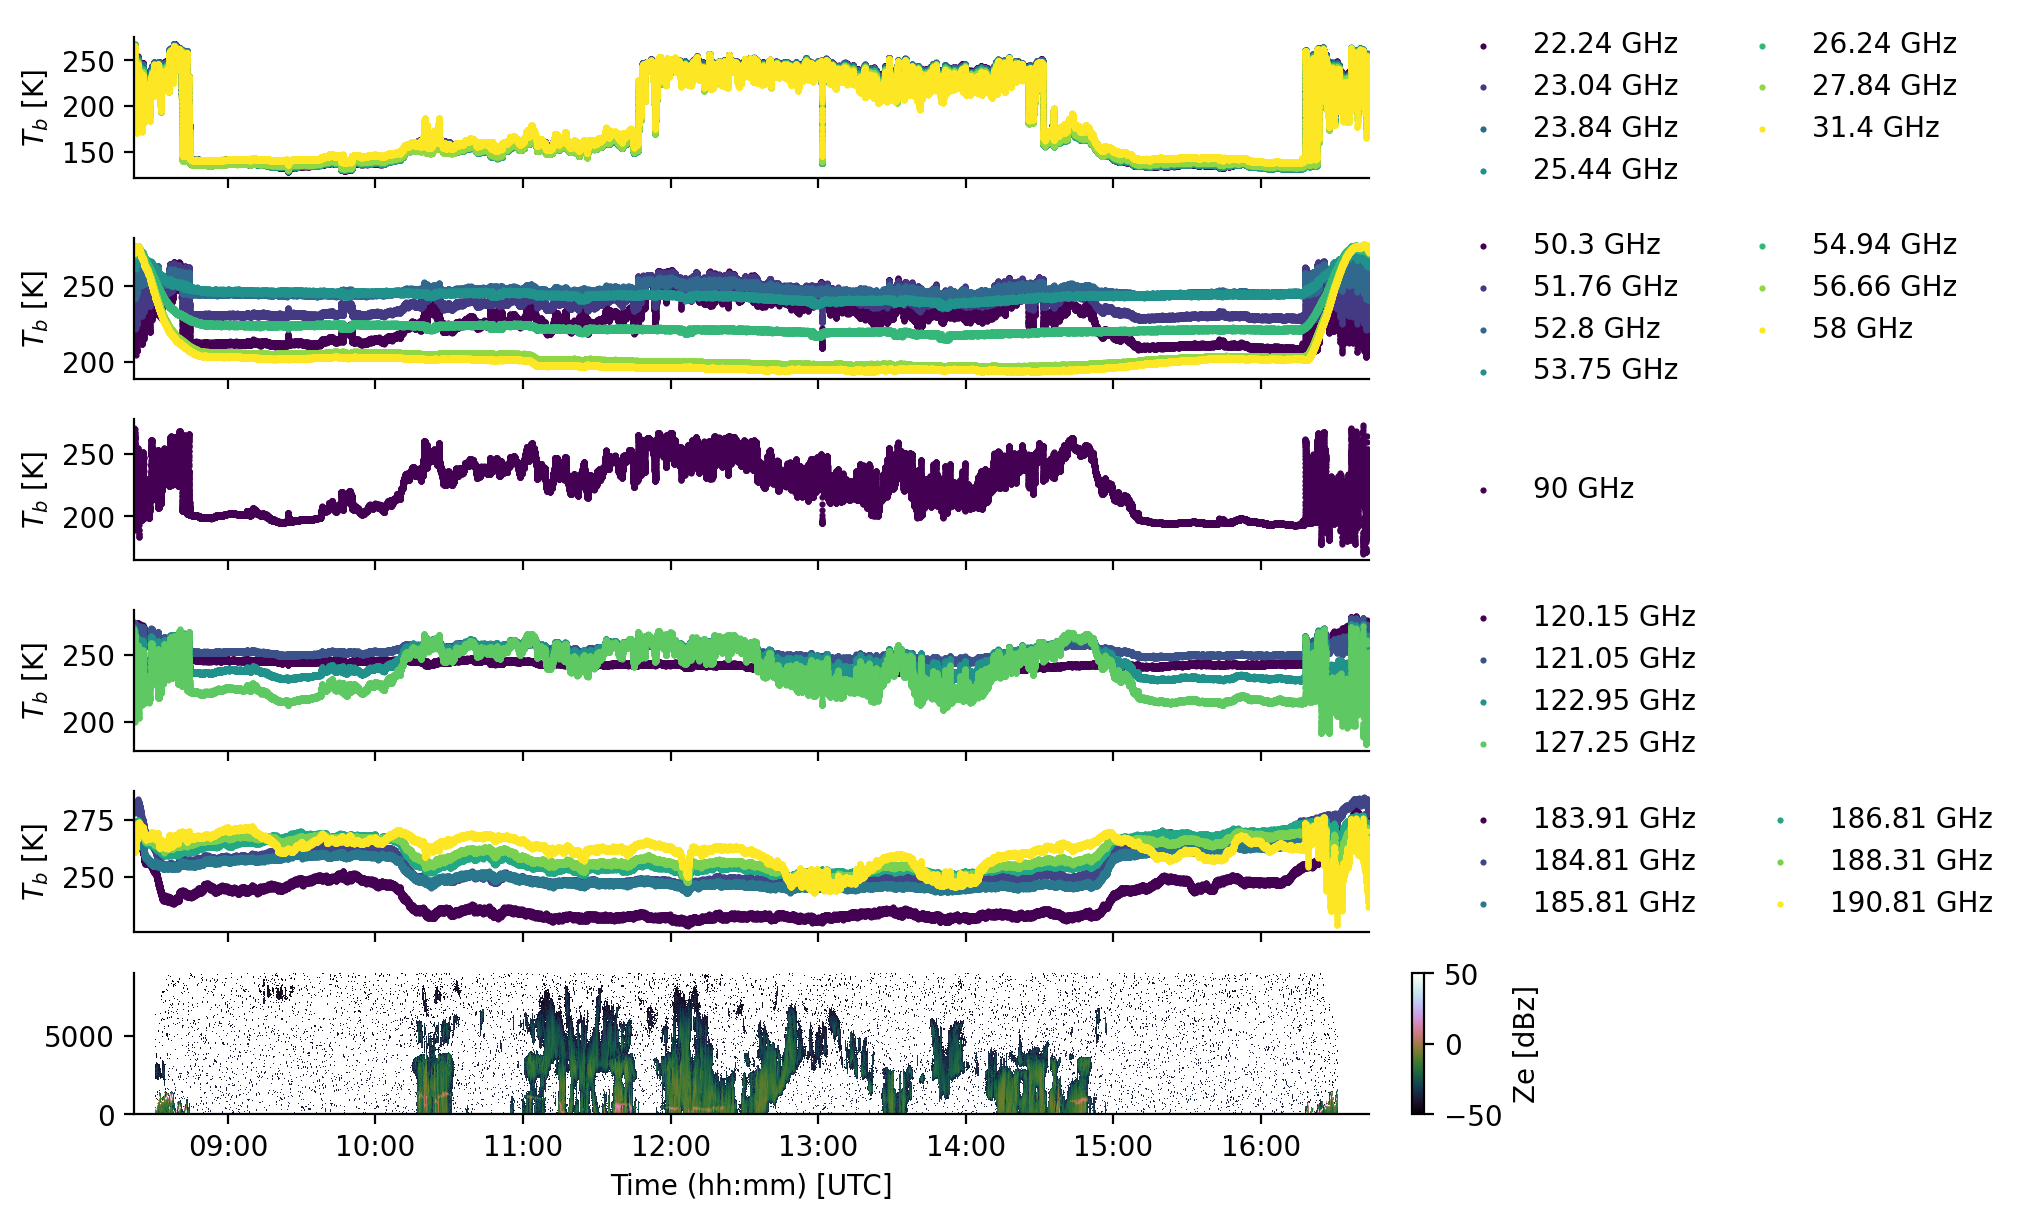

In [11]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, sharex=True, gridspec_kw=dict(height_ratios=(1, 1, 1, 1, 1, 1)))

kwargs = dict(s=5, linewidths=0)
colors = cm.get_cmap('viridis', 7).colors
for i in range(0, 7):
    ax1.scatter(hamp_kv.time, hamp_kv.TBs[:,i], label='%g GHz'%hamp_kv.Freq[i], color=colors[i], **kwargs)

for i in range(7, 14):
    ax2.scatter(hamp_kv.time, hamp_kv.TBs[:,i], label='%g GHz'%hamp_kv.Freq[i], color=colors[i-7], **kwargs)

ax1.legend(frameon=False, bbox_to_anchor=(1.05, 0.5), loc='center left', ncol=2)
ax2.legend(frameon=False, bbox_to_anchor=(1.05, 0.5), loc='center left', ncol=2)

ax1.set_ylabel('$T_b$ [K]')
ax2.set_ylabel('$T_b$ [K]')

colors = cm.get_cmap('viridis', 5).colors
for i in range(0, 1):
    ax3.scatter(hamp_11990.time, hamp_11990.TBs[:,i], label='%g GHz'%hamp_11990.Freq[i], color=colors[i], **kwargs)

for i in range(1, 5):
    ax4.scatter(hamp_11990.time, hamp_11990.TBs[:,i], label='%g GHz'%hamp_11990.Freq[i], color=colors[i-1], **kwargs)

ax3.legend(frameon=False, bbox_to_anchor=(1.05, 0.5), loc='center left')
ax4.legend(frameon=False, bbox_to_anchor=(1.05, 0.5), loc='center left')
    
ax3.set_ylabel('$T_b$ [K]')
ax4.set_ylabel('$T_b$ [K]')

colors = cm.get_cmap('viridis', 6).colors
for i in range(0, 6):
    ax5.scatter(hamp_183.time, hamp_183.TBs[:,i], label='%g GHz'%hamp_183.Freq[i], color=colors[i], **kwargs)

ax5.legend(frameon=False, bbox_to_anchor=(1.05, 0.5), loc='center left', ncol=2)

ax5.set_ylabel('$T_b$ [K]')

im = ax6.pcolormesh(time_2d, alt_2d, 10*np.log10(hamp_mira.Ze.T), vmin=-50, vmax=50, cmap='cubehelix', shading='nearest')
ax6.set_xlim([takeoff,landing])
ax6.set_ylim([0,9000])
ax6.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax6.set_xlabel('Time (hh:mm) [UTC]')

fig.colorbar(im, ax=ax6, label='Ze [dBz]')

plt.show()

In [12]:
np.__version__

'1.20.1'